# Setup libraries and working data
Load libraries and set up working directories.

In [1]:
import os
import os.path
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
from math import ceil
from random import random
import json

from shapely.geometry import Point
from shapely.geometry import shape
import matplotlib.pyplot as plt
import contextily as ctx
from tqdm.notebook import tqdm
tqdm.pandas()

import rasterio
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask
from rasterio.features import shapes
from rasterio.features import dataset_features

from pyproj import CRS

%matplotlib inline

DROOT = '../1-data/'
os.makedirs(os.path.join(DROOT, '3-interim', 'populationmasks'), exist_ok=True)

pd.set_option('display.max_columns', None)


# General methods
Define methods to be used in the procedures below.

In [2]:
# Convert single GeoDataFrame Polygon to GeoJSON
def get_mask_coords(gdf): 
    """Get the first polygon in a GeoDataFrame as GeoJSON."""
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [3]:
def mask_popcenter_from_raster(gdf_entry, raster, tiff_out):
    
    out_img, out_transform = mask(
        dataset=raster, 
        shapes=get_mask_coords(gdf_entry), 
        crop=True)

    # Write out for usage a bit further onwards due to limitations in rasterio.
    out_meta = pop.meta.copy()
    out_meta.update({
        "driver": "GTiff",
         "height": out_img.shape[1],
         "width": out_img.shape[2],
         "transform": out_transform,
         "crs": pop.crs
    })

    with rasterio.open(tiff_out, "w", **out_meta) as dest:
        dest.write(out_img)

### Load information files

In [4]:
# Get population data for the whole world.
pop = rasterio.open(os.path.join(
    DROOT,
    '2-external',
    'GHS_POP_E2020_GLOBE_R2022A_54009_100_V1_0',
    'GHS_POP_E2020_GLOBE_R2022A_54009_100_V1_0.tif'))
pop.shape, pop.bounds, pop.crs.to_proj4()

((180000, 360820),
 BoundingBox(left=-18041000.0, bottom=-9000000.0, right=18041000.0, top=9000000.0),
 '+proj=moll +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs=True')

In [5]:
# Open Urban Centers file, it's pretty big.
urbancenter_gdf = gpd.read_file( os.path.join(
    DROOT, 
    '2-external',
    'GHS_STAT_UCDB2015MT_GLOBE_R2019A',
    'GHS_STAT_UCDB2015MT_GLOBE_R2019A_V1_2.gpkg')).to_crs(pop.crs)
urbancenter_gdf.head(1)

ID_HDC_G0  QA2_1V   AREA  BBX_LATMN   BBX_LONMN  BBX_LATMX   BBX_LONMX   
0        1.0     1.0  185.0  21.247683 -158.043016  21.422193 -157.730529  \

   GCPNT_LAT   GCPNT_LON      CTR_MN_NM CTR_MN_ISO  XBRDR  XCTR_NBR   
0  21.340678 -157.893497  United States        USA    0.0       1.0  \

       XC_NM_LST XC_ISO_LST           GRGN_L1           GRGN_L2  UC_NM_MN   
0  United States        USA  Northern America  Northern America  Honolulu  \

                             UC_NM_LST  UC_NM_SRC  H75_NBR  H90_NBR  H00_NBR   
0  Honolulu; Waipahu; Pearl City; Aiea  GISCO OSM      1.0      1.0      1.0  \

   H75_AREA  H90_AREA  H00_AREA   
0     115.0     152.0     174.0  \

                                      E_BM_NM_LST   E_SL_LST  EL_AV_ALS   
0  Tropical and Subtropical Dry Broadleaf Forests  Vertisols  52.296435  \

  E_KG_NM_LST E_RB_NM_LST   E_WR_P_90   E_WR_P_00   E_WR_P_14  E_WR_T_90   
0         NAN         NAN  955.500031  620.975021  741.625015  23.456032  \

   E_WR_T_00  E_WR_T_14      B75      B90        B00        B15   
0  23.153346  23.526622  78.8452  78.8452  80.214867  80.647377  \

             P75            P90            P00            P15     BUCAP75   
0  277211.196645  378482.072123  458967.881664  512853.666675  284.422854  \

      BUCAP90     BUCAP00     BUCAP15     NTL_AV      GDP90_SM      GDP00_SM   
0  208.319509  174.772288  157.252219  24.768574  1.504144e+10  1.584126e+10  \

       GDP15_SM INCM_CMI DEV_CMI         TT2CC  E_GR_AV90  E_GR_AV00   
0  2.192668e+10      HIC     MDR  15412.057919   0.231515   0.349464  \

   E_GR_AV14  E_GR_AH90  E_GR_AM90  E_GR_AL90   E_GR_AT90  E_GR_AH00   
0    0.36929   3.310453  129.41213  51.089083  179.678081  56.331924  \

    E_GR_AM00  E_GR_AL00   E_GR_AT00  E_GR_AH14  E_GR_AM14  E_GR_AL14   
0  113.192717  14.287026  183.811667  70.317059  98.455611  15.038997  \

    E_GR_AT14    E_EC2E_E75    E_EC2E_E90    E_EC2E_E00     E_EC2E_E15   
0  183.811667  2.867485e+06  1.265081e+06  1.012234e+06  495299.593436  \

      E_EC2E_R75     E_EC2E_R90     E_EC2E_R00     E_EC2E_R15     E_EC2E_I75   
0  456114.038821  403581.138607  462973.483368  396627.287294  598840.500466  \

      E_EC2E_I90     E_EC2E_I00     E_EC2E_I15     E_EC2E_T75     E_EC2E_T90   
0  601347.375094  541277.833862  456837.498271  208651.075028  276910.085019  \

      E_EC2E_T00     E_EC2E_T15  E_EC2E_A75  E_EC2E_A90  E_EC2E_A00   
0  341852.064389  345201.327942    0.013626    0.029494    0.042942  \

   E_EC2E_A15  E_EC2O_E75     E_EC2O_E90    E_EC2O_E00    E_EC2O_E15   
0    0.056613         NaN  156371.556763  42922.159473  11381.377166  \

   E_EC2O_R75    E_EC2O_R90    E_EC2O_R00   E_EC2O_R15  E_EC2O_I75   
0         NaN  13811.961727  11022.504909  8225.571851         NaN  \

     E_EC2O_I90    E_EC2O_I00    E_EC2O_I15  E_EC2O_T75  E_EC2O_T90   
0  29257.399703  67747.537985  51154.996318         NaN         NaN  \

    E_EC2O_T00    E_EC2O_T15  E_EC2O_A75  E_EC2O_A90  E_EC2O_A00  E_EC2O_A15   
0  1029.574596  10692.735959    2.418542      3.1539    2.293634    3.078804  \

   E_EPM2_E75  E_EPM2_E90  E_EPM2_E00  E_EPM2_E15  E_EPM2_R75  E_EPM2_R90   
0   300.28759  134.342385   98.071016   41.850553   88.248068  112.991622  \

   E_EPM2_R00  E_EPM2_R15  E_EPM2_I75  E_EPM2_I90  E_EPM2_I00  E_EPM2_I15   
0   68.033587   40.144556  118.767334  208.712524  224.997453  174.221274  \

   E_EPM2_T75  E_EPM2_T90  E_EPM2_T00  E_EPM2_T15  E_EPM2_A75  E_EPM2_A90   
0   29.250431   43.893797     29.3647   23.536766    0.042916    0.043009  \

   E_EPM2_A00  E_EPM2_A15  E_CPM2_T00  E_CPM2_T05  E_CPM2_T10  E_CPM2_T14   
0    0.041517    0.047534    7.237346     6.15893    5.563796    5.765125  \

   EX_FD_AREA  EX_FD_B75  EX_FD_B90  EX_FD_B00  EX_FD_B15  EX_FD_P75   
0         0.0        0.0        0.0        0.0        0.0        0.0  \

   EX_FD_P90  EX_FD_P00  EX_FD_P15  EX_SS_AREA  EX_SS_B75  EX_SS_B90   
0        0.0        0.0        0.0       161.0  68.280144  68.280144  \

   EX_SS_B00

Name: Amsterdam


CTR_MN_NM CTR_MN_ISO XC_ISO_LST   UC_NM_MN  UC_NM_LST
2166  Netherlands        NLD        NLD  Amsterdam  Amsterdam

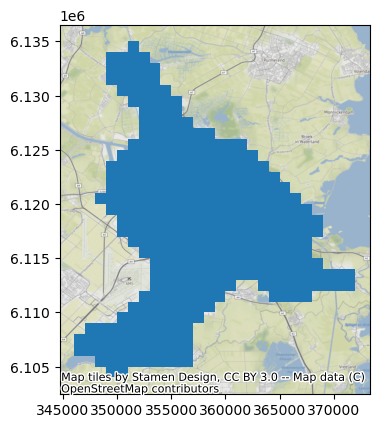

In [6]:
name = input('Name: ')
result = urbancenter_gdf[urbancenter_gdf.UC_NM_LST.str.contains(name)]
ax = result.plot()
ctx.add_basemap(ax, crs=result.crs)
result[['CTR_MN_NM', 'CTR_MN_ISO', 'XC_ISO_LST', 'UC_NM_MN', 'UC_NM_LST']]

In [7]:
# Open Functional Urban Areas file
fua_gdf = gpd.read_file( os.path.join(
    DROOT, 
    '2-external',
    'GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0',
    'GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0.gpkg')).to_crs(pop.crs)

fua_gdf.head(1)

eFUA_ID  UC_num UC_IDs eFUA_name  Commuting Cntry_ISO   Cntry_name   
0      1.0     1.0   5959     Herat        1.0       AFG  Afghanistan  \

   FUA_area  UC_area     FUA_p_2015      UC_p_2015    Com_p_2015   
0     139.0     60.0  888811.175807  844574.564331  44236.611476  \

                                            geometry  
0  MULTIPOLYGON (((5529000.000 4155000.000, 55310...

Name (Barcelona / Amsterdam): Amsterdam
Country ISO (ESP / NLD): NLD


eFUA_ID  eFUA_name Cntry_ISO    FUA_p_2015
6470   1427.0  Amsterdam       NLD  1.929350e+06

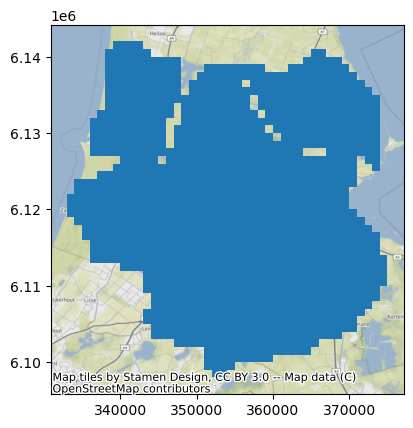

In [8]:
name = input('Name (Barcelona / Amsterdam): ')
country = input('Country ISO (ESP / NLD): ')
result = fua_gdf[(fua_gdf.eFUA_name.str.contains(name)) & (fua_gdf.Cntry_ISO == country)]
ax = result.plot()
ctx.add_basemap(ax, crs=result.crs)
result[['eFUA_ID', 'eFUA_name', 'Cntry_ISO', 'FUA_p_2015']]

In [55]:
np.random.random(image.shape)

array([[0.59208799, 0.80110788, 0.9686247 , ..., 0.05177138, 0.60901399,
        0.59406329],
       [0.49933335, 0.29617324, 0.07955406, ..., 0.74451805, 0.62697893,
        0.7101    ],
       [0.52866984, 0.78568774, 0.52723709, ..., 0.57778062, 0.37291091,
        0.6280453 ],
       ...,
       [0.84245683, 0.26807794, 0.11651207, ..., 0.75394567, 0.87076881,
        0.80317912],
       [0.74085715, 0.22612508, 0.50547047, ..., 0.73971041, 0.7536228 ,
        0.05209939],
       [0.41582283, 0.9043695 , 0.59992839, ..., 0.0538826 , 0.52050649,
        0.13089311]])

In [58]:
tiff_path = os.path.join(DROOT, '3-interim', 'populationmasks', 
                         'Amsterdam' + '.tiff')
pcl_path  = os.path.join(DROOT, '3-interim', 'populationmasks', 
                         'Amsterdam' + '.pcl')

# Write out a masked selection with city population.
mask_popcenter_from_raster(
    gdf_entry=fua_gdf[
        (fua_gdf.eFUA_name.str.contains(name)) & 
        (fua_gdf.Cntry_ISO == country)],
    raster=pop,
    tiff_out=tiff_path
)

# Convert the masked tiff to geojson for GeoPandas to use.
# This is doing the heavy lifting!
with rasterio.open(tiff_path) as raster:
    image = raster.read(1)

    # Add tiny random deviation (<1) so units don't join together
    #   in the next shapes() method. 
    image -= np.random.random(image.shape)
    print(image)

    crs = raster.crs
    print(crs)
    list_pop = [
        {'cell_pop': value, 'geometry': shape(shp)}
        for i, (shp, value) 
        in enumerate(shapes(image, transform=raster.transform))
        if value > raster.nodata
    ]

# Read in as a GeoPandas dataset and write out. 
gdf_pop = gpd.GeoDataFrame(list_pop, crs=crs)
gdf_pop.cell_pop = np.maximum(gdf_pop.cell_pop, 0)
gdf_pop.to_pickle(pcl_path)

[[-200.83199825 -200.48905604 -200.0695196  ... -200.11122826
  -200.83092588 -200.13420043]
 [-200.78319276 -200.61544887 -200.75995901 ... -200.23145688
  -200.40365787 -200.13218928]
 [-200.33162125 -200.66659477 -200.73353394 ... -200.10663366
  -200.26076058 -200.73197093]
 ...
 [-200.4531582  -200.28235475 -200.89514664 ... -200.05324931
  -200.7936045  -200.33344109]
 [-200.83304613 -200.00626283 -200.44898711 ... -200.00808449
  -200.60117378 -200.37108221]
 [-200.09322041 -200.20479651 -200.70317704 ... -200.30973167
  -200.86595351 -200.21760589]]
ESRI:54009


ValueError: image dtype must be one of: int16, int32, uint8, uint16, float32

In [51]:
type(raster.read(1))

numpy.ndarray

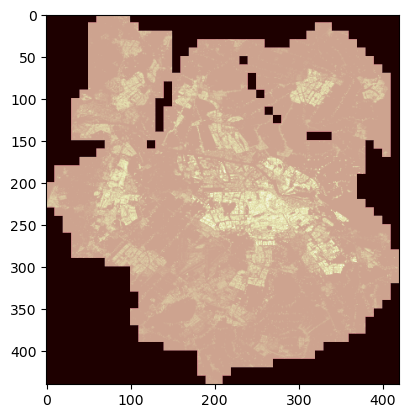

In [45]:
raster = rasterio.open(tiff_path)
plt.imshow(raster.read(1), cmap='pink')

# Procedures
Load two files and start masking the listed cities.

In [44]:
city_list_df = pd.read_csv(os.path.join(DROOT, '1-raw', 'citylist.csv'))
city_list_itr = tqdm(city_list_df.itertuples(), leave=False)

os.makedirs(os.path.join(DROOT, '3-interim', 'populationmasks'), exist_ok=True)

# Get masked population dataframes for all mentioned cities.
for city in city_list_itr:
    
    city_list_itr.set_description("Current city: {}".format(city.City))

    tiff_path = os.path.join(DROOT, '3-interim', 'populationmasks', 
                             city.City + '.tiff')
    pcl_path  = os.path.join(DROOT, '3-interim', 'populationmasks', 
                             city.City + '.pcl')
    
    # If city already done, skip this.
    if(os.path.exists(tiff_path) and False
       and os.path.exists(pcl_path)):
        continue;
    
    # Write out a masked selection with city population.
    mask_popcenter_from_raster(
        gdf_entry=urbancenter_gdf[
            (urbancenter_gdf.UC_NM_MN == city.City) &
            (urbancenter_gdf.XC_ISO_LST == city.Country)
        ],
        raster=pop,
        tiff_out=tiff_path
    )
    
    # Convert the masked tiff to geojson for GeoPandas to use.
    # This is doing the heavy lifting!
    with rasterio.open(tiff_path) as raster:
        image = raster.read(1)
        
        # Add tiny random deviation (<1) so units don't join together
        #   in the next shapes() method. 
        for row in range(len(image)):
            for col in range(len(image[row])):
                image[row,col] -= random()
        
        crs = raster.crs
        list_pop = [
            {'cell_pop': value, 'geometry': shape(shp)}
            for i, (shp, value) 
            in enumerate(shapes(image, transform=raster.transform))
            if value > raster.nodata
        ]
    
    # Read in as a GeoPandas dataset and write out. 
    gdf_pop = gpd.GeoDataFrame(list_pop, crs=crs)
    gdf_pop.cell_pop = np.maximum(gdf_pop.cell_pop, 0)
    gdf_pop.to_pickle(pcl_path)


In [45]:
gdf_pop.to_crs(epsg=4326).centroid[200:240]

/Users/ivo/opt/anaconda3/envs/thesis-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


200    POINT (-74.07374 4.78903)
201    POINT (-74.07124 4.78903)
202    POINT (-74.06874 4.78903)
203    POINT (-74.06625 4.78903)
204    POINT (-74.06375 4.78903)
205    POINT (-74.06125 4.78903)
206    POINT (-74.05875 4.78903)
207    POINT (-74.05625 4.78903)
208    POINT (-74.05375 4.78903)
209    POINT (-74.05125 4.78903)
210    POINT (-74.04875 4.78903)
211    POINT (-74.04625 4.78903)
212    POINT (-74.04375 4.78903)
213    POINT (-74.04125 4.78903)
214    POINT (-74.03875 4.78903)
215    POINT (-74.03625 4.78903)
216    POINT (-74.09361 4.78701)
217    POINT (-74.09111 4.78701)
218    POINT (-74.08861 4.78701)
219    POINT (-74.08611 4.78701)
220    POINT (-74.08361 4.78701)
221    POINT (-74.08111 4.78701)
222    POINT (-74.07861 4.78701)
223    POINT (-74.07611 4.78701)
224    POINT (-74.07361 4.78701)
225    POINT (-74.07111 4.78701)
226    POINT (-74.06861 4.78701)
227    POINT (-74.06611 4.78701)
228    POINT (-74.06361 4.78701)
229    POINT (-74.06111 4.78701)
230    POI

In [46]:
gdf_pop.to_crs(epsg=4326).centroid[200::400]

/Users/ivo/opt/anaconda3/envs/thesis-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


200     POINT (-74.07374 4.78903)
600     POINT (-74.12185 4.76069)
1000    POINT (-74.13078 4.74449)
1400    POINT (-74.21996 4.73234)
1800    POINT (-74.10944 4.72425)
2200    POINT (-74.02892 4.71615)
2600    POINT (-74.15823 4.70602)
3000    POINT (-74.22756 4.69590)
3400    POINT (-74.11691 4.68578)
3800    POINT (-74.12598 4.67161)
4200    POINT (-74.17492 4.65541)
4600    POINT (-74.18400 4.64124)
5000    POINT (-74.15322 4.62909)
5400    POINT (-74.13244 4.61695)
5800    POINT (-74.12166 4.60480)
6200    POINT (-74.10088 4.59265)
6600    POINT (-74.17009 4.58051)
7000    POINT (-74.06947 4.57039)
7400    POINT (-74.20866 4.55824)
7800    POINT (-74.11791 4.54609)
8200    POINT (-74.14623 4.51978)
8600    POINT (-74.10358 4.47727)
dtype: geometry